In [1]:
import tensorflow as tf

# Clear any existing GPU settings
tf.keras.backend.clear_session()

# Set TensorFlow to run on GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allow memory growth to prevent OOM (Out-of-Memory) errors
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set up successfully!")
    except RuntimeError as e:
        print(f"GPU Setup Error: {e}")

2025-04-12 07:07:07.782374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744441627.986643      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744441628.045941      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU is set up successfully!


In [2]:
import tensorflow as tf
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from PIL import Image
import shutil

In [3]:
# Define dataset paths
dataset1_path = "/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets"
dataset2_path = "/kaggle/input/iqothnccd-lung-cancer-dataset/The IQ-OTHNCCD lung cancer dataset/The IQ-OTHNCCD lung cancer dataset"
combined_dataset_path = "/kaggle/working/Combined_Lung_Dataset"

# Mapping folders to 3-class structure
datasets = {
    "lung_n": "Normal",
    "Normal cases": "Normal",
    "Bengin cases": "Benign",
    "lung_aca": "Malignant",
    "lung_scc": "Malignant",
    "Malignant cases": "Malignant",
}

# Make sure combined class folders exist
for category in set(datasets.values()):
    os.makedirs(os.path.join(combined_dataset_path, category), exist_ok=True)

# Function to copy & rename images with prefix
def copy_images(source_folder, target_folder, prefix):
    if os.path.exists(source_folder):
        for file in os.listdir(source_folder):
            if file.lower().endswith((".jpg", ".png", ".jpeg")):
                src_path = os.path.join(source_folder, file)
                new_filename = f"{prefix}_{file}"
                dst_path = os.path.join(target_folder, new_filename)
                shutil.copy(src_path, dst_path)

# Copy dataset 1 (H&E histology) → add "histo_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset1_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="histo")

# Copy dataset 2 (CT scans) → add "ct_" prefix
for folder, category in datasets.items():
    source_folder = os.path.join(dataset2_path, folder)
    target_folder = os.path.join(combined_dataset_path, category)
    copy_images(source_folder, target_folder, prefix="ct")

# Cleanup: remove any empty folders
for category in set(datasets.values()):
    target_folder = os.path.join(combined_dataset_path, category)
    if len(os.listdir(target_folder)) == 0:
        print(f"Removing empty folder: {target_folder}")
        shutil.rmtree(target_folder)

print("✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!")


✅ Dataset successfully merged into 3 classes: Normal, Benign, Malignant with histo/ct prefixes!


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5223978875921796208
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16266690560
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6710815314467060055
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


I0000 00:00:1744441830.951947      31 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
import os
import shutil

# === Paths ===
real_benign = "/kaggle/working/Combined_Lung_Dataset/Benign"
synthetic_benign = "/kaggle/input/gan-images-iq-othnccd-benign"
target_non_malignant = "/kaggle/working/Combined_Lung_Dataset/Non-Malignant"

# Create target folder
os.makedirs(target_non_malignant, exist_ok=True)

# === Copy Real Benign Images (prefix: real_) ===
for filename in os.listdir(real_benign):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(real_benign, filename)
        dst = os.path.join(target_non_malignant, f"real_{filename}")
        shutil.copyfile(src, dst)

# === Copy Synthetic Benign Images (prefix: ct_synthetic_) ===
for filename in os.listdir(synthetic_benign):
    if filename.lower().endswith('.png'):  # All synthetic are .png
        src = os.path.join(synthetic_benign, filename)
        dst = os.path.join(target_non_malignant, f"ct_synthetic_{filename}")
        shutil.copyfile(src, dst)

print(f"✅ Combined Real + Synthetic Benign images into: {target_non_malignant}")
print(f"🧾 Total: {len(os.listdir(target_non_malignant))} images")


✅ Combined Real + Synthetic Benign images into: /kaggle/working/Combined_Lung_Dataset/Non-Malignant
🧾 Total: 5120 images


In [6]:
# === Define paths ===
root_dataset = "/kaggle/working/Combined_Lung_Dataset"
normal_dir = os.path.join(root_dataset, "Normal")
benign_combined_dir = os.path.join(root_dataset, "Non-Malignant")  # this contains real + synthetic Benign
malignant_dir = os.path.join(root_dataset, "Malignant")

# Final binary class folder
final_dataset = "/kaggle/working/Final_Binary_Dataset"
final_non_malignant = os.path.join(final_dataset, "Non-Malignant")
final_malignant = os.path.join(final_dataset, "Malignant")

# === Create directories ===
os.makedirs(final_non_malignant, exist_ok=True)
os.makedirs(final_malignant, exist_ok=True)

# === Copy Normal images to Non-Malignant ===
for file in os.listdir(normal_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(normal_dir, file)
        dst = os.path.join(final_non_malignant, f"normal_{file}")
        shutil.copyfile(src, dst)

# === Copy Benign (real + synthetic) to Non-Malignant ===
for file in os.listdir(benign_combined_dir):
    if file.lower().endswith('.png') or file.lower().endswith(('.jpg', '.jpeg')):
        src = os.path.join(benign_combined_dir, file)
        dst = os.path.join(final_non_malignant, file)
        shutil.copyfile(src, dst)

# === Copy Malignant images ===
for file in os.listdir(malignant_dir):
    if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        src = os.path.join(malignant_dir, file)
        dst = os.path.join(final_malignant, file)
        shutil.copyfile(src, dst)

print("✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset")
print(f"📁 Non-Malignant: {len(os.listdir(final_non_malignant))} images")
print(f"📁 Malignant: {len(os.listdir(final_malignant))} images")


✅ Final Binary Dataset structure created at /kaggle/working/Final_Binary_Dataset
📁 Non-Malignant: 10536 images
📁 Malignant: 10561 images


In [7]:
import os
import numpy as np

image_paths = []
labels = []
label_dict = {}
data_dir = "/kaggle/working/Final_Binary_Dataset"
for idx, class_name in enumerate(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            image_paths.append(file_path)
            labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("✅ Loaded image paths and labels.")
print("🔢 Label Mapping:", label_dict)
print("📦 Total Images:", len(image_paths))



✅ Loaded image paths and labels.
🔢 Label Mapping: {'Non-Malignant': 0, 'Malignant': 1}
📦 Total Images: 21097


In [8]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

data_dir = "/kaggle/working/Final_Binary_Dataset"
np.random.seed(42)

image_paths = []
labels = []
synthetic_paths = []
synthetic_labels = []
label_dict = {}

# === Load image paths and separate synthetic ===
for idx, class_name in enumerate(sorted(os.listdir(data_dir))):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
        label_dict[class_name] = idx
        for file in os.listdir(class_dir):
            full_path = os.path.join(class_dir, file)
            if class_name == "Non-Malignant" and file.startswith("synthetic_"):
                synthetic_paths.append(full_path)
                synthetic_labels.append(idx)
            else:
                image_paths.append(full_path)
                labels.append(idx)

image_paths = np.array(image_paths)
labels = np.array(labels)
synthetic_paths = np.array(synthetic_paths)
synthetic_labels = np.array(synthetic_labels)

# === Split real data into 70% train, 20% val, 10% test ===
X_temp, X_test, y_temp, y_test = train_test_split(
    image_paths, labels, test_size=0.1, stratify=labels, random_state=42)

X_train_real, X_val, y_train_real, y_val = train_test_split(
    X_temp, y_temp, test_size=2/9, stratify=y_temp, random_state=42)  # 2/9 of 90% → ~20%

# === Add synthetic data to training set only ===
X_train = np.concatenate((X_train_real, synthetic_paths))
y_train = np.concatenate((y_train_real, synthetic_labels))

# === Done ===
print("✅ 70/20/10 Split complete (synthetic used only in training).")
print(f"📦 Training Set: {len(X_train)} images (with synthetic)")
print(f"🧪 Validation Set: {len(X_val)} images (real only)")
print(f"🧫 Test Set: {len(X_test)} images (real only)")


✅ 70/20/10 Split complete (synthetic used only in training).
📦 Training Set: 14767 images (with synthetic)
🧪 Validation Set: 4220 images (real only)
🧫 Test Set: 2110 images (real only)


In [9]:
import numpy as np
from collections import Counter

def print_distribution(y, name=""):
    counts = Counter(y)
    total = len(y)
    print(f"📊 {name} Set Distribution:")
    for label, count in sorted(counts.items()):
        percentage = (count / total) * 100
        print(f"  Class {label} → {count} samples ({percentage:.2f}%)")
    print(f"  Total: {total} images\n")

# Example:
print_distribution(y_train, "Train")
print_distribution(y_val, "Validation")
print_distribution(y_test, "Test")


📊 Train Set Distribution:
  Class 0.0 → 7392 samples (50.06%)
  Class 1.0 → 7375 samples (49.94%)
  Total: 14767 images

📊 Validation Set Distribution:
  Class 0 → 2113 samples (50.07%)
  Class 1 → 2107 samples (49.93%)
  Total: 4220 images

📊 Test Set Distribution:
  Class 0 → 1056 samples (50.05%)
  Class 1 → 1054 samples (49.95%)
  Total: 2110 images



In [10]:
# Parameters
image_size = (256, 256)
mean = tf.convert_to_tensor([0.485, 0.456, 0.406], dtype=tf.float32)
std = tf.convert_to_tensor([0.229, 0.224, 0.225], dtype=tf.float32)

I0000 00:00:1744441887.134925      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [11]:
'''
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.005)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    return image, label
'''

'\n@tf.function\ndef augment_image(image, label, filename):\n    # Apply base spatial transforms to all images\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_flip_up_down(image)\n\n    if tf.random.uniform([]) > 0.7:\n        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)\n        image = tf.image.rot90(image, k)\n\n    # === Conditional Augmentations ===\n    # For histopathology images (H&E)\n    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):\n        if tf.random.uniform([]) > 0.7:\n            image = tf.image.random_brightness(image, max_delta=0.08)\n        if tf.random.uniform([]) > 0.7:\n            image = tf.image.random_contrast(image, 0.9, 1.1)\n        if tf.random.uniform([]) > 0.7:\n            image = tf.image.random_saturation(image, 0.9, 1.1)\n        if tf.random.uniform([]) > 0.9:\n            image = tf.image.random_jpeg_quality(image, 80, 100)\n        if tf.random.uniform([]) > 0.7:\n        

In [12]:
'''
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            # Brightness for histopathology images (H&E)
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.005)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations for CT
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            # Slight noise for CT images
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        if tf.random.uniform([]) > 0.2:  # Small probability for brightness change for CT
            image = tf.image.random_brightness(image, max_delta=0.02)  # Small brightness for CT scans

    return image, label
'''

'\n@tf.function\ndef augment_image(image, label, filename):\n    # Apply base spatial transforms to all images\n    image = tf.image.random_flip_left_right(image)\n    image = tf.image.random_flip_up_down(image)\n\n    if tf.random.uniform([]) > 0.7:\n        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)\n        image = tf.image.rot90(image, k)\n\n    # === Conditional Augmentations ===\n    # For histopathology images (H&E)\n    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):\n        if tf.random.uniform([]) > 0.7:\n            # Brightness for histopathology images (H&E)\n            image = tf.image.random_brightness(image, max_delta=0.08)\n        if tf.random.uniform([]) > 0.7:\n            image = tf.image.random_contrast(image, 0.9, 1.1)\n        if tf.random.uniform([]) > 0.7:\n            image = tf.image.random_saturation(image, 0.9, 1.1)\n        if tf.random.uniform([]) > 0.9:\n            image = tf.image.random_jpeg_quality(image, 8

In [13]:
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations for CT
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            # Slight noise for CT images
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        if tf.random.uniform([]) > 0.2:  # Small probability for brightness change for CT
            image = tf.image.random_brightness(image, max_delta=0.02)  # Small brightness for CT scans

    return image, label


In [14]:
# ================= Preprocessing Function ================= #
def load_and_preprocess_image(image_path, label, augment=False):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    print("Before normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = img / 255.0  # Normalize pixel values
    print("After division by 255:", tf.reduce_min(img), tf.reduce_max(img))
    # Apply augmentation only if augment=True
    if augment:
        img, label = augment_image(img, label, filename)
    print("After mean/std normalization:", tf.reduce_min(img), tf.reduce_max(img))
    img = (img - mean) / std  # Apply mean-std normalization
    img = tf.cast(img, tf.float32)
    return img, label

In [15]:
# ================= Dataset Creation ================= #
def create_dataset(image_paths, labels, batch_size=32, shuffle=True, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(len(image_paths))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [16]:

# Create datasets
train_dataset = create_dataset(X_train, y_train, augment=True)  # Augmentation only in training
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)


Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)
Before normalization: Tensor("Min:0", shape=(), dtype=float32) Tensor("Max:0", shape=(), dtype=float32)
After division by 255: Tensor("Min_1:0", shape=(), dtype=float32) Tensor("Max_1:0", shape=(), dtype=float32)
After mean/std normalization: Tensor("Min_2:0", shape=(), dtype=float32) Tensor("Max_2:0", shape=(), dtype=float32)


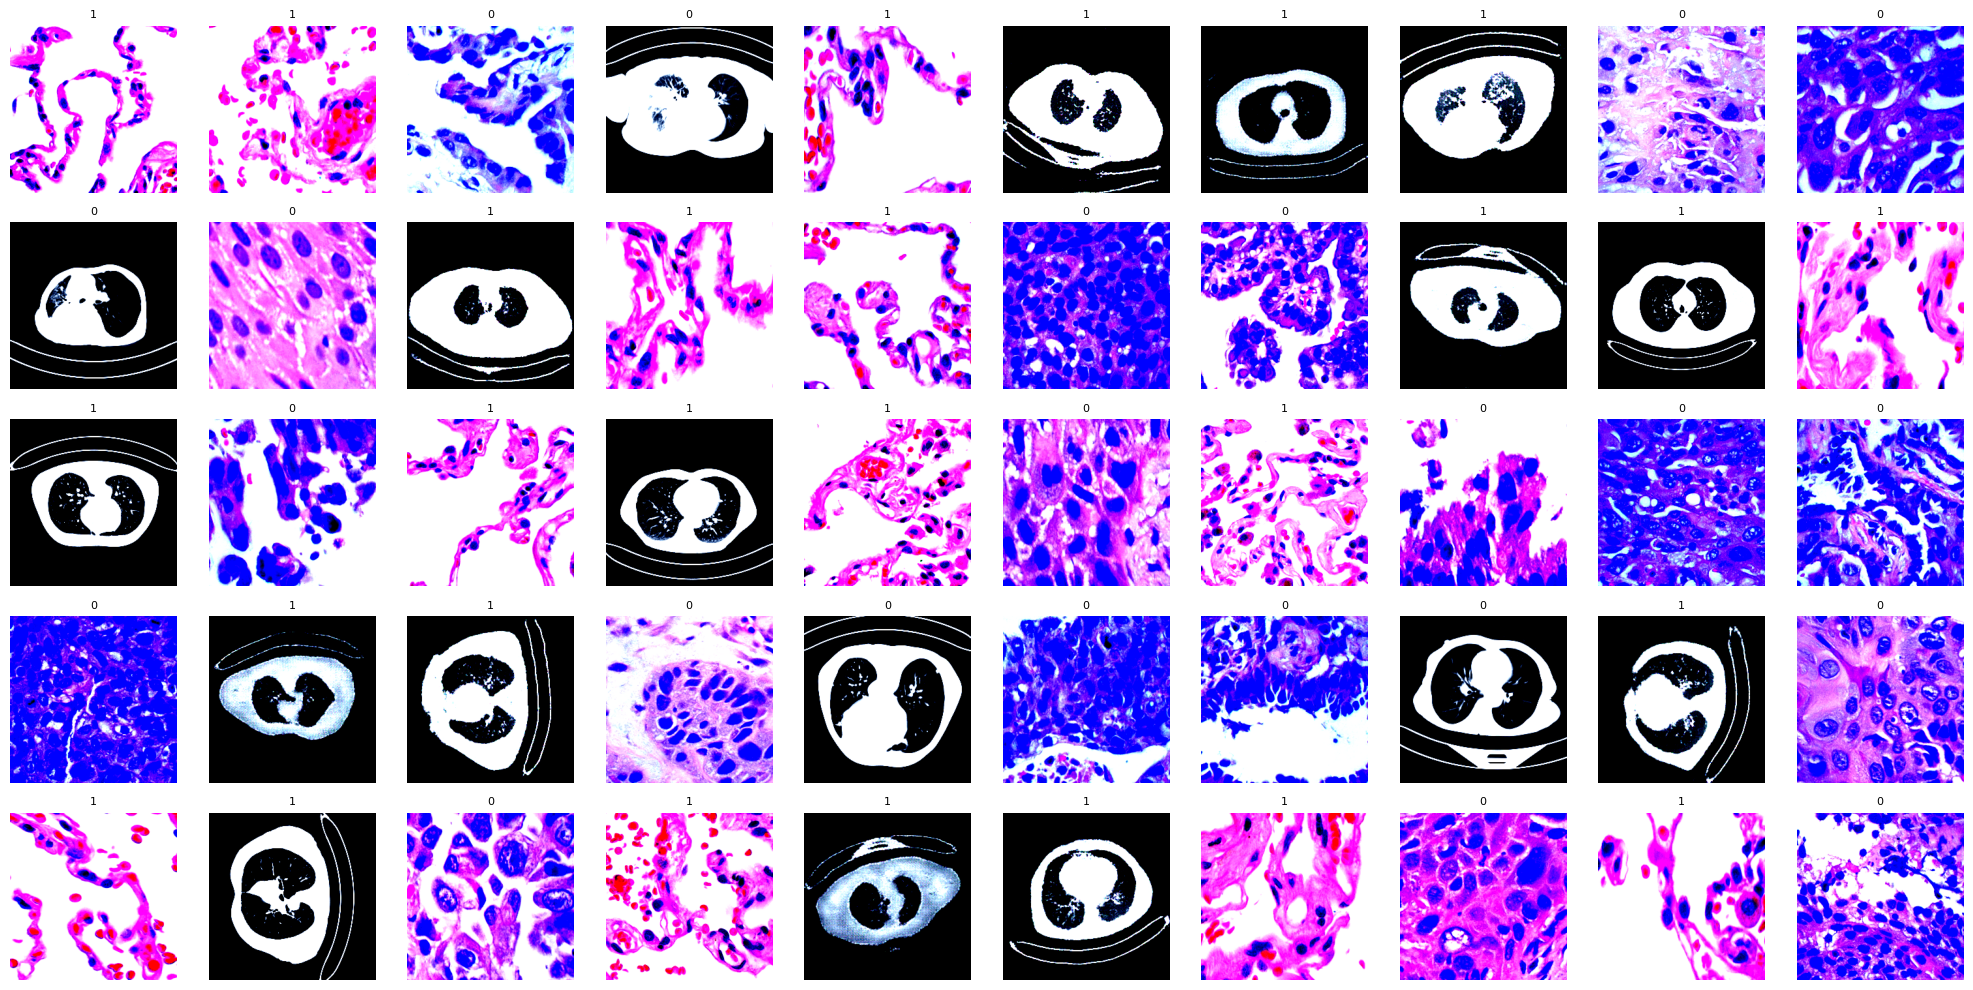

In [17]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Take batches and flatten to 50 individual images
images = []
labels = []

# Collect 50 images
for batch_images, batch_labels in train_dataset:
    for i in range(len(batch_images)):
        images.append(batch_images[i])
        labels.append(batch_labels[i])
        if len(images) == 50:
            break
    if len(images) == 50:
        break

# Plot 50 images in a 10x5 grid
plt.figure(figsize=(20, 10))  # Adjust size as needed

for i in range(50):
    plt.subplot(5, 10, i + 1)
    plt.imshow(tf.clip_by_value(images[i], 0.0, 1.0).numpy())
    plt.title(f"{int(labels[i])}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
'''
# ✅ Full EfficientNetB1 Training Pipeline with Optimized Train Accuracy (256x256)

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# ================== Model Builder ==================#
def create_efficientnetB1_model(input_shape=(256, 256, 3), num_classes=1, learning_rate=0.0001):
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze initially

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return base_model, model

# ================== Learning Rate Scheduler ==================#
def scheduler(epoch, lr):
    return lr if epoch < 5 else lr * 0.5

callback_lr = LearningRateScheduler(scheduler)

# ================== Early Stopping & Checkpoint ==================#
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model_b1.keras", monitor='val_loss', save_best_only=True, verbose=1)

# ================== Get the Model ==================#
base_model, model = create_efficientnetB1_model(input_shape=(256, 256, 3))

# ================== Initial Training (Frozen Base) ==================#
history_lr_scheduler = model.fit(
    train_dataset,  # Already batched
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callback_lr, early_stopping, model_checkpoint],
    verbose=1
)

# ================== Fine-tuning ==================#
base_model.trainable = True
fine_tune_at = 50  # Unfreeze more layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),  # Use SGD with momentum
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Longer fine-tuning
    callbacks=[early_stopping],
    verbose=1
)

# ================== Evaluation ==================#
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

# ================== Plot Accuracy & Loss ==================#
plt.plot(history_lr_scheduler.history['accuracy'], label='Train Accuracy')
plt.plot(history_lr_scheduler.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_lr_scheduler.history['loss'], label='Train Loss')
plt.plot(history_lr_scheduler.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# ================== Save Final Model ==================#
model.save('/kaggle/working/efficientnet_b1_lung_model.keras')
'''

'\n# ✅ Full EfficientNetB1 Training Pipeline with Optimized Train Accuracy (256x256)\n\nimport tensorflow as tf\nfrom tensorflow.keras import layers, models\nfrom tensorflow.keras.applications import EfficientNetB1\nfrom tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint\nimport matplotlib.pyplot as plt\nimport os\n\n# ================== Model Builder ==================#\ndef create_efficientnetB1_model(input_shape=(256, 256, 3), num_classes=1, learning_rate=0.0001):\n    base_model = EfficientNetB1(weights=\'imagenet\', include_top=False, input_shape=input_shape)\n    base_model.trainable = False  # Freeze initially\n\n    inputs = tf.keras.Input(shape=input_shape)\n    x = base_model(inputs, training=False)\n    x = layers.GlobalAveragePooling2D()(x)\n    x = layers.Dense(512, activation=\'relu\', kernel_regularizer=tf.keras.regularizers.l2(1e-5))(x)\n    outputs = layers.Dense(num_classes, activation=\'sigmoid\')(x)\n    model = models.Model(inpu

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


I0000 00:00:1744441988.190234      93 service.cc:148] XLA service 0x7cdf20001ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744441988.191584      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744441990.787812      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/462 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.5347 - loss: 0.6942   

I0000 00:00:1744442004.333949      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6013 - loss: 0.6557
Epoch 1: val_loss improved from inf to 0.63280, saving model to best_model_b1.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 127s 122ms/step - accuracy: 0.6014 - loss: 0.6557 - val_accuracy: 0.6318 - val_loss: 0.6328 - learning_rate: 1.0000e-04
Epoch 2/10
462/462 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6235 - loss: 0.6417
Epoch 2: val_loss improved from 0.63280 to 0.62745, saving model to best_model_b1.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.6235 - loss: 0.6417 - val_accuracy: 0.6289 - val_loss: 0.6275 - learning_rate: 1.0000e-04
Epoch 3/10
461/462 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6256 - loss: 0.6390
Epoch 3: val_loss improved from 0.62745 to 0.62737, saving model to best_model_b1.keras
462/462 ━━━━━━━━━━━━━━━━━━━━ 54s 56ms/step - accuracy: 0.6256 - loss: 0.6389 - val_accuracy: 0.6270 - val_loss: 0.6274 - learning_rate: 1.0000e-04
Epoch 4/10
461/462 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms

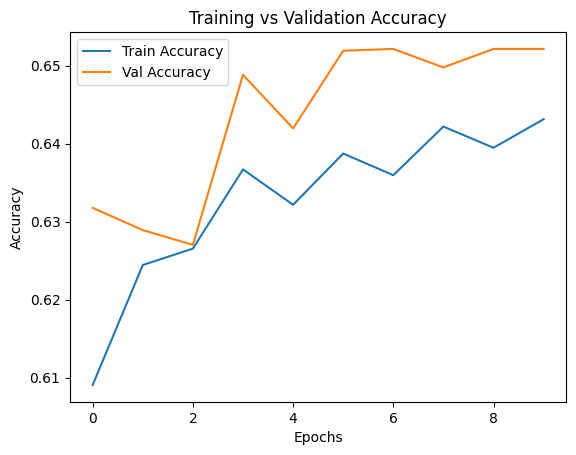

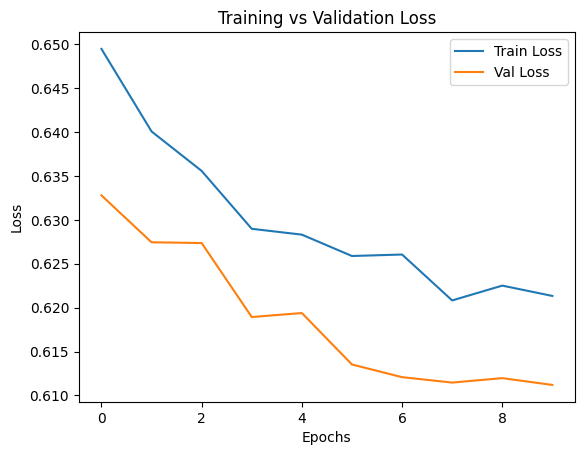

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# ✅ Enable Mixed Precision
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16")

# ================== Model Builder ==================#
def create_efficientnetB1_model(input_shape=(256, 256, 3), num_classes=1, learning_rate=0.0001):
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze initially

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6))(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',  # Changed loss function
        metrics=['accuracy']
    )
    return base_model, model

# ================== Learning Rate Scheduler ==================#
def scheduler(epoch, lr):
    return lr if epoch < 5 else lr * 0.5

callback_lr = LearningRateScheduler(scheduler)

# ================== Early Stopping & Checkpoint ==================#
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint("best_model_b1.keras", monitor='val_loss', save_best_only=True, verbose=1)

# ================== Augmentation Function ==================#
@tf.function
def augment_image(image, label, filename):
    # Apply base spatial transforms to all images
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)

    if tf.random.uniform([]) > 0.7:
        k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k)

    # === Conditional Augmentations ===
    # For histopathology images (H&E)
    if tf.strings.regex_full_match(filename, ".*histo.*|.*real.*"):
        if tf.random.uniform([]) > 0.7:
            # Brightness for histopathology images (H&E)
            image = tf.image.random_brightness(image, max_delta=0.08)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_contrast(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.random_saturation(image, 0.9, 1.1)
        if tf.random.uniform([]) > 0.9:
            image = tf.image.random_jpeg_quality(image, 80, 100)
        if tf.random.uniform([]) > 0.7:
            image = tf.image.central_crop(image, 0.9)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.7:
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.01)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # For CT/synthetic images
    elif tf.strings.regex_full_match(filename, ".*ct.*|.*synthetic.*"):
        # Less aggressive augmentations for CT
        if tf.random.uniform([]) > 0.8:
            image = tf.image.central_crop(image, 0.95)
            image = tf.image.resize(image, [256, 256])
        if tf.random.uniform([]) > 0.8:
            # Slight noise for CT images
            noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.002)
            image = tf.clip_by_value(image + noise, 0.0, 1.0)
        if tf.random.uniform([]) > 0.2:  # Small probability for brightness change for CT
            image = tf.image.random_brightness(image, max_delta=0.02)  # Small brightness for CT scans

    return image, label

# ================== Get the Model ==================#
base_model, model = create_efficientnetB1_model(input_shape=(256, 256, 3))

# ================== Initial Training (Frozen Base) ==================#
history_lr_scheduler = model.fit(
    train_dataset,  # Already batched
    validation_data=val_dataset,
    epochs=10,
    callbacks=[callback_lr, early_stopping, model_checkpoint],
    verbose=1
)

# ================== Fine-tuning ==================#
base_model.trainable = True
fine_tune_at = 50  # Unfreeze more layers
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),  # Use SGD with momentum
    loss='binary_crossentropy',  # Changed loss function
    metrics=['accuracy']
)

history_fine = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,  # Longer fine-tuning
    callbacks=[early_stopping],
    verbose=1
)

# ================== Evaluation ==================#
test_loss, test_acc = model.evaluate(test_dataset)
print(f"\n✅ Test Accuracy: {test_acc * 100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

# ================== Plot Accuracy & Loss ==================#
plt.plot(history_lr_scheduler.history['accuracy'], label='Train Accuracy')
plt.plot(history_lr_scheduler.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history_lr_scheduler.history['loss'], label='Train Loss')
plt.plot(history_lr_scheduler.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

# ================== Save Final Model ==================#
model.save('/kaggle/working/efficientnet_b1_lung_model.h5')


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━

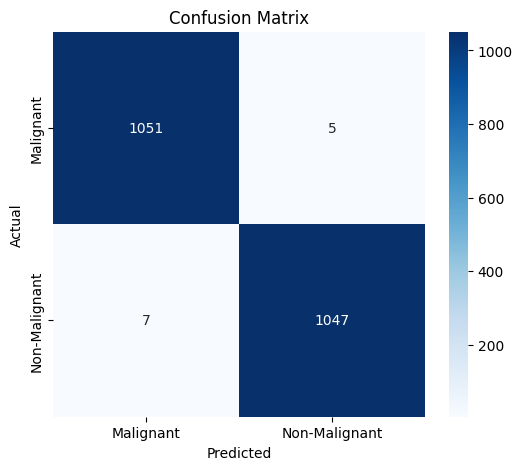

✅ Model Evaluation Metrics:
Accuracy     : 99.43%
Macro F1     : 0.9943
Precision    : 0.9943
Recall       : 0.9943
AUROC        : 0.9998

Classification Report:
               precision    recall  f1-score   support

    Malignant       0.99      1.00      0.99      1056
Non-Malignant       1.00      0.99      0.99      1054

     accuracy                           0.99      2110
    macro avg       0.99      0.99      0.99      2110
 weighted avg       0.99      0.99      0.99      2110



In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score

# === Run Predictions ===
y_true = []
y_pred = []
y_prob = []

for x_batch, y_batch in test_dataset:
    probs = model.predict(x_batch).flatten()
    preds = (probs > 0.5).astype(int)

    y_true.extend(y_batch.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# === Metrics ===
accuracy = np.mean(y_true == y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
auroc = roc_auc_score(y_true, y_prob)

# === Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Malignant", "Non-Malignant"], yticklabels=["Malignant", "Non-Malignant"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# === Print Results ===
print("✅ Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy * 100:.2f}%")
print(f"Macro F1     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"AUROC        : {auroc:.4f}")

# === Classification Report ===
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=["Malignant", "Non-Malignant"]))


In [22]:
!zip -r /kaggle/working/efficientnet_b1_lung_model.zip /kaggle/working/efficientnet_b1_lung_model.h5

  adding: kaggle/working/efficientnet_b1_lung_model.h5 (deflated 8%)


In [23]:
plt.savefig('/kaggle/working/confusion_matrix.png')  # Save confusion matrix as an image

# === Save Results to a Text File ===
with open('/kaggle/working/model_evaluation.txt', 'w') as f:
    f.write("✅ Model Evaluation Metrics:\n")
    f.write(f"Accuracy     : {accuracy * 100:.2f}%\n")
    f.write(f"Macro F1     : {f1:.4f}\n")
    f.write(f"Precision    : {precision:.4f}\n")
    f.write(f"Recall       : {recall:.4f}\n")
    f.write(f"AUROC        : {auroc:.4f}\n")
    
    f.write("\nClassification Report:\n")
    f.write(classification_report(y_true, y_pred, target_names=["Malignant", "Non-Malignant"]))

# === Print Results ===
print("✅ Model Evaluation Metrics:")
print(f"Accuracy     : {accuracy * 100:.2f}%")
print(f"Macro F1     : {f1:.4f}")
print(f"Precision    : {precision:.4f}")
print(f"Recall       : {recall:.4f}")
print(f"AUROC        : {auroc:.4f}")


✅ Model Evaluation Metrics:
Accuracy     : 99.43%
Macro F1     : 0.9943
Precision    : 0.9943
Recall       : 0.9943
AUROC        : 0.9998


<Figure size 640x480 with 0 Axes>